<a href="https://colab.research.google.com/github/surodoot/Quantum-Computing/blob/main/Crosstalk_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygsti networkx numpy scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygsti: filename=pyGSTi-0.9.13-cp311-cp311-linux_x86_64.whl size=17241221 sha256=d8926ffcb22f5be8d631fa802372f0d0c000218b9aa637e58a822430cc0d3e40
  Stored in directory: /root/.cache/pip/wheels/ee/e3/72/47bbdb055908dfd7871cf3c53b754523886590bcc18ca00d9c
Successfully built pygsti


In [ ]:
import pygsti
import numpy as np
import networkx as nx
import random
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


In [ ]:
def generate_crosstalk_experiments(M, L, Ncircs, Ncon, pidle):
    """
    크로스토크 감지 실험을 생성하는 함수
    M: 지역(region) 개수
    L: 회로 깊이(depth)
    Ncircs: 각 지역에서 사용할 서브 회로 개수
    Ncon: 각 서브 회로를 몇 개의 컨텍스트에서 테스트할 것인가
    pidle: idle 회로가 선택될 확률
    """
    experiments = []

    # 각 지역에 대해 서브 회로 모음(Bag)을 랜덤으로 생성
    bags = {m: [f"circ_{m}_{n}" for n in range(Ncircs)] for m in range(M)}

    for m in range(M):
        for n in range(Ncircs):
            sm = bags[m][n]  # 지역 m의 n번째 서브회로

            for c in range(Ncon):
                experiment = {}
                for k in range(M):
                    if k == m:
                        experiment[k] = sm  # 해당 지역에 선택된 서브 회로 적용
                    else:
                        if random.uniform(0, 1) < pidle:
                            experiment[k] = "idle"
                        else:
                            experiment[k] = random.choice(bags[k])

                experiments.append(experiment)

    # 중복 실험 제거
    experiments = [dict(t) for t in {tuple(sorted(d.items())) for d in experiments}]

    return experiments


In [ ]:
import numpy as np
from collections import defaultdict
from scipy.stats import chi2_contingency

def conditional_independence_test(data, X, Y, cond_set):
    contingency_table = defaultdict(int)


    for row in data:
        key = (row[X], row[Y]) + tuple(row[var] for var in cond_set)
        contingency_table[key] += 1


    print(f"\nTesting {X} ⟂ {Y} | {cond_set}")
    print("Contingency Table (Raw):", dict(contingency_table))

    # 리스트 변환 후, 부족한 값이 있으면 0으로 채우기
    table_values = list(contingency_table.values())


    while len(table_values) % 2 != 0:
        table_values.append(0)


    min_size = max(4, len(table_values) // 2 * 2)  # 최소 2x2 유지
    while len(table_values) < min_size:
        table_values.append(0)


    try:
        table = np.array(table_values).reshape(-1, 2)
    except ValueError as e:
        print("ValueError 발생, 테이블 크기:", len(table_values), " | 패딩 후 테이블:", table_values)
        return 1


    if np.any(table.sum(axis=0) == 0) or np.any(table.sum(axis=1) == 0):
        print("경고: 카이제곱 실행 불가! 빈 행렬 발견")
        return 1

    # 카이제곱 검정 실행
    try:
        chi2, p, _, _ = chi2_contingency(table)
    except ValueError as e:
        print("ValueError 발생, 자동으로 크기 조정 시도:", e)
        return 1  # 기본적으로 독립적이지 않다고 판단

    print(f"p-value: {p}")
    return p


In [ ]:
def pc_algorithm(data, variables, alpha=0.5):
    """
    PC 알고리즘을 사용하여 크로스토크 그래프를 생성하는 함수
    data: 실험 데이터
    variables: 변수 리스트
    alpha: p-value 임계값 (default = 0.05)
    """
    import networkx as nx
    from itertools import combinations

    G = nx.Graph()
    G.add_nodes_from(variables)

    # 초기에는 모든 변수 간에 간선이 존재
    for X, Y in combinations(variables, 2):
        G.add_edge(X, Y)

    # 조건부 독립성을 검정하면서 간선을 제거
    n = 0
    while True:
        removed_edges = []

        for X, Y in list(G.edges):
            neighbors = list(G.neighbors(X))
            neighbors.remove(Y)

            if len(neighbors) >= n:
                for cond_set in combinations(neighbors, n):
                    p_value = conditional_independence_test(data, X, Y, cond_set)

                    if p_value > alpha:  # p-value가 크면 독립이라고 판단하여 간선 제거
                        removed_edges.append((X, Y))
                        break

        if not removed_edges:
            break  # 더 이상 제거할 간선이 없으면 종료

        G.remove_edges_from(removed_edges)
        n += 1

    return G


{0: 'circ_0_0', 1: 'circ_1_2', 2: 'circ_2_0', 3: 'circ_3_0'}
{0: 'circ_0_3', 1: 'circ_1_3', 2: 'circ_2_4', 3: 'circ_3_2'}
{0: 'circ_0_0', 1: 'circ_1_3', 2: 'idle', 3: 'circ_3_4'}
{0: 'circ_0_2', 1: 'circ_1_4', 2: 'circ_2_4', 3: 'circ_3_4'}
{0: 'idle', 1: 'circ_1_1', 2: 'circ_2_0', 3: 'idle'}
{0: 'circ_0_0', 1: 'circ_1_4', 2: 'circ_2_1', 3: 'circ_3_3'}
{0: 'circ_0_3', 1: 'circ_1_4', 2: 'circ_2_2', 3: 'circ_3_1'}
{0: 'circ_0_2', 1: 'circ_1_2', 2: 'circ_2_3', 3: 'circ_3_2'}
{0: 'circ_0_3', 1: 'idle', 2: 'circ_2_4', 3: 'circ_3_2'}
{0: 'circ_0_3', 1: 'circ_1_1', 2: 'circ_2_1', 3: 'circ_3_0'}
{0: 'circ_0_0', 1: 'circ_1_2', 2: 'circ_2_0', 3: 'circ_3_1'}
{0: 'circ_0_1', 1: 'circ_1_2', 2: 'circ_2_4', 3: 'circ_3_4'}
{0: 'circ_0_4', 1: 'circ_1_3', 2: 'circ_2_1', 3: 'circ_3_3'}
{0: 'circ_0_2', 1: 'circ_1_1', 2: 'circ_2_2', 3: 'circ_3_3'}
{0: 'idle', 1: 'circ_1_4', 2: 'circ_2_4', 3: 'circ_3_3'}
{0: 'circ_0_3', 1: 'circ_1_2', 2: 'circ_2_4', 3: 'circ_3_4'}
{0: 'circ_0_0', 1: 'circ_1_3', 2: 'circ_2_2'

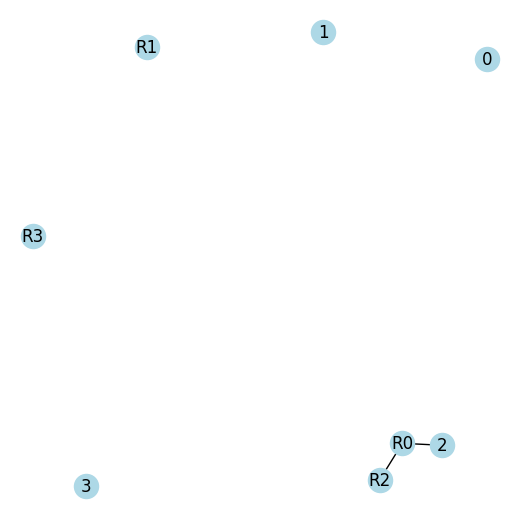

In [ ]:
# 예제 데이터 생성
sample_data = [
    {"S0": "circ_0_1", "S1": "circ_1_2", "R0": 0, "R1": 0},
    {"S0": "circ_0_2", "S1": "circ_1_3", "R0": 0, "R1": 1},
    {"S0": "circ_0_3", "S1": "circ_1_4", "R0": 1, "R1": 1},
    {"S0": "circ_0_4", "S1": "circ_1_1", "R0": 0, "R1": 0},
]

# # PC 알고리즘 실행
# graph = pc_algorithm(sample_data, ["S0", "S1", "R0", "R1"])

experiments = generate_crosstalk_experiments(M=4, L=5, Ncircs=5, Ncon=5, pidle=0.1)
for exp in experiments:
    print(exp)

import random

# 측정 결과를 추가하는 과정
sample_data = []
for exp in experiments:
    exp_with_results = exp.copy()  # 기존 서브서킷 데이터 복사
    exp_with_results["R0"] = random.choice([0, 1])  # 측정값 추가
    exp_with_results["R1"] = random.choice([0, 1])
    exp_with_results["R2"] = random.choice([0, 1])
    exp_with_results["R3"] = random.choice([0, 1])
    sample_data.append(exp_with_results)

# 최종 데이터 출력
for data in sample_data:
    print(data)

graph = pc_algorithm(sample_data, [0, 1, 2,3,"R0", "R1", "R2", "R3"])
# graph = pc_algorithm(sample_data, ["S0", "S1", "R0", "R1"])

plt.figure(figsize=(5, 5))
nx.draw(graph, with_labels=True, node_color="lightblue", edge_color="black")
plt.show()
